# Base classifer

A classifer to detect if an autograph sign is present in an image od a document.  
The model is trained on few examples belonging to 2 classes: positive and negative samples.

In [17]:
import os
import shutil
import random
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2, MobileNetV2
from tensorflow.keras import layers, models

## preparazione del dataset

In [14]:
# Percorso al dataset originale
SOURCE_DIR = Path("./datasets/custom1")
# Directory di output
TARGET_DIR = Path("./datasets/custom1combined")

# Suddivisione in percentuali
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Etichette
classes = ["positive", "negative"]

# 1️⃣ Crea cartelle di output
for split in ["train", "val", "test"]:
    for c in classes:
        (TARGET_DIR / split / c).mkdir(parents=True, exist_ok=True)

# 2️⃣ Raccogli tutte le immagini positive e negative
all_images = {c: [] for c in classes}

for source in SOURCE_DIR.iterdir():
    if source.is_dir():
        for c in classes:
            class_dir = source / c
            if class_dir.exists():
                images = list(class_dir.glob("*"))
                all_images[c].extend(images)

print(f"Trovate {len(all_images['positive'])} positive e {len(all_images['negative'])} negative immagini.")

# 3️⃣ Divide in train / val / test
for c in classes:
    imgs = all_images[c]
    random.shuffle(imgs)

    train_imgs, temp_imgs = train_test_split(imgs, test_size=(1 - train_ratio), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

    # 4️⃣ Copia i file
    for img in train_imgs:
        shutil.copy(img, TARGET_DIR / "train" / c / img.name)
    for img in val_imgs:
        shutil.copy(img, TARGET_DIR / "val" / c / img.name)
    for img in test_imgs:
        shutil.copy(img, TARGET_DIR / "test" / c / img.name)

print("✅ Dataset unificato e diviso in train/val/test.")

Trovate 82 positive e 59 negative immagini.
✅ Dataset unificato e diviso in train/val/test.


verifica del bilanciamento

In [15]:
for split in ["train", "val", "test"]:
    for c in classes:
        count = len(list((TARGET_DIR / split / c).glob("*")))
        print(f"{split}/{c}: {count}")

train/positive: 55
train/negative: 33
val/positive: 12
val/negative: 8
test/positive: 13
test/negative: 9


converte le immagini a 3 canali

In [9]:
from PIL import Image
from PIL import Image
from pathlib import Path
from collections import Counter

root = Path("datasets/custom1combined")  # modifica se serve
modes = Counter()
exts = {'.jpg', '.jpeg', '.png'}

root = Path("datasets/custom1combined")
for p in root.rglob("*"):
    if p.suffix.lower() in exts and p.is_file():
        with Image.open(p) as im:
            if im.mode != 'RGB':
                im.convert('RGB').save(p)

## caricamento del dataset

In [21]:
# Percorso al dataset combinato
DATASET_DIR = "datasets/custom1combined"

# Parametri
IMG_SIZE = (int(500*0.754), 500)
# IMG_SIZE = (224, 224)
BATCH_SIZE = 16

def ensure_three_channels(x):
    # x può essere (H,W), (H,W,1) o (H,W,3)
    if x.ndim == 2:
        x = np.stack([x, x, x], axis=-1)
    if x.shape[-1] == 1:
        x = np.repeat(x, 3, axis=-1)
    return x


# 1️⃣ Data augmentation + normalizzazione
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=ensure_three_channels
)

val_test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=ensure_three_channels)

# 2️⃣ Generator per ciascun set
train_data = train_datagen.flow_from_directory(
    directory=f"{DATASET_DIR}/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb', 
    class_mode='binary'
)

val_data = val_test_datagen.flow_from_directory(
    directory=f"{DATASET_DIR}/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb', 
    class_mode='binary'
)

test_data = val_test_datagen.flow_from_directory(
    directory=f"{DATASET_DIR}/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb', 
    class_mode='binary',
    shuffle=False  # per valutazione
)

print("✅ Generatori Keras creati con successo.")

Found 88 images belonging to 2 classes.


Found 20 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
✅ Generatori Keras creati con successo.


## training

In [22]:
# 2️⃣ Modello pre-addestrato
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # Freeza i pesi

# 3️⃣ Aggiungi classificatore finale
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4️⃣ Addestra
model.fit(train_data, validation_data=val_data, epochs=10)

C:\Users\matti\AppData\Local\Temp\ipykernel_18288\2147816321.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
c:\Users\matti\anaconda3\envs\cv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6364 - loss: 0.6873 - val_accuracy: 0.6000 - val_loss: 0.6645
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6364 - loss: 0.6509 - val_accuracy: 0.6000 - val_loss: 0.6613
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6250 - loss: 0.6379 - val_accuracy: 0.6000 - val_loss: 0.6474
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6477 - loss: 0.6397 - val_accuracy: 0.6000 - val_loss: 0.6368
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6705 - loss: 0.6119 - val_accuracy: 0.6000 - val_loss: 0.6229
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6591 - loss: 0.6048 - val_accuracy: 0.6000 - val_loss: 0.6170
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7045 - loss: 0.5724 - val_accuracy: 0.6000 - val_loss: 0.6213
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6591 - loss: 0.5971 - val_accuracy: 0.6000 - val_loss: 0.6095
Epoch 9/

## evaluation

1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepWARNING:tensorflow:5 out of the last 19 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002039B1AA980> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Evaluation metrics:
accuracy: 0.6818181818181818
precision: 0.65
recall: 1.0
f1: 0.7878787878787878


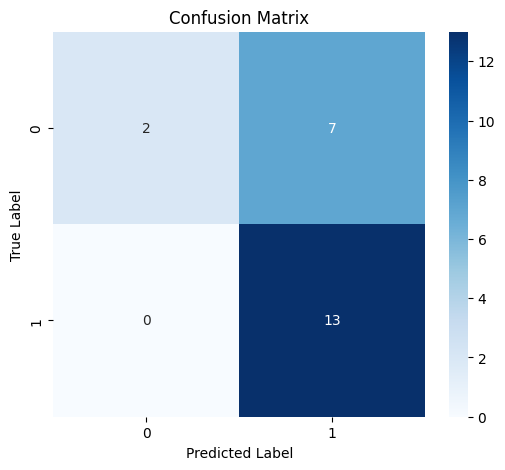

In [23]:
y_probs = model.predict(test_data)  # shape (N,1)

# Flatten and get predicted labels
y_true = test_data.classes  # integer labels from the generator
y_probs = np.array(y_probs).reshape(-1)
y_pred = (y_probs > 0.5).astype(int)

# Compute metrics
metrics = {}
metrics['accuracy'] = float(accuracy_score(y_true, y_pred))
metrics['precision'] = float(precision_score(y_true, y_pred, zero_division=0))
metrics['recall'] = float(recall_score(y_true, y_pred, zero_division=0))
metrics['f1'] = float(f1_score(y_true, y_pred, zero_division=0))


# Confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)

# Print summary
print('Evaluation metrics:')
for k, v in metrics.items():
    if k in ['confusion_matrix', 'classification_report']:
        continue
    print(f'{k}: {v}')

# Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()